**1. Data Preparation**

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Load the data
df = pd.read_excel(r'c:\Users\Admin\Documents\EXCELR\DS Assignments\@\heart_disease.xlsx', sheet_name='Heart_disease')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (908, 13)

First few rows:
   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  False      2.3  downsloping  fixed defect    0  
1  False      0.0         flat  fixed defect    0  
2  False      0.4         flat  fixed defect    0  
3  False      0.0         flat  fixed defect    0  
4   True      1.5         flat  fixed defect    0  

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  --

**2. Exploratory Data Analysis (EDA)**

Descriptive statistics:
              age    trestbps        chol      thalch     oldpeak         num
count  908.000000  908.000000  908.000000  908.000000  846.000000  908.000000
mean    53.791850  133.430617  201.484581  135.957048    0.891253    1.008811
std      9.158031   20.401608  112.097949   26.804929    1.093875    1.144436
min     29.000000    0.000000    0.000000   60.000000   -2.600000    0.000000
25%     47.750000  120.000000  176.750000  118.000000    0.000000    0.000000
50%     54.000000  130.000000  224.000000  138.000000    0.500000    1.000000
75%     60.000000  144.000000  270.000000  156.000000    1.500000    2.000000
max     77.000000  200.000000  603.000000  202.000000    6.200000    4.000000

Target variable distribution:
num
0    399
1    265
2    109
3    107
4     28
Name: count, dtype: int64


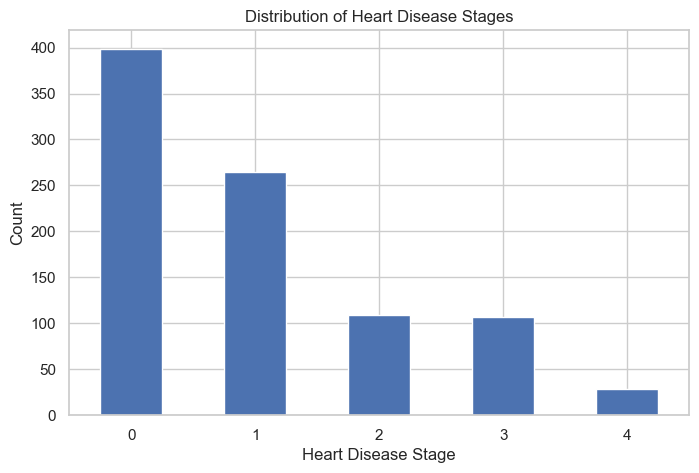

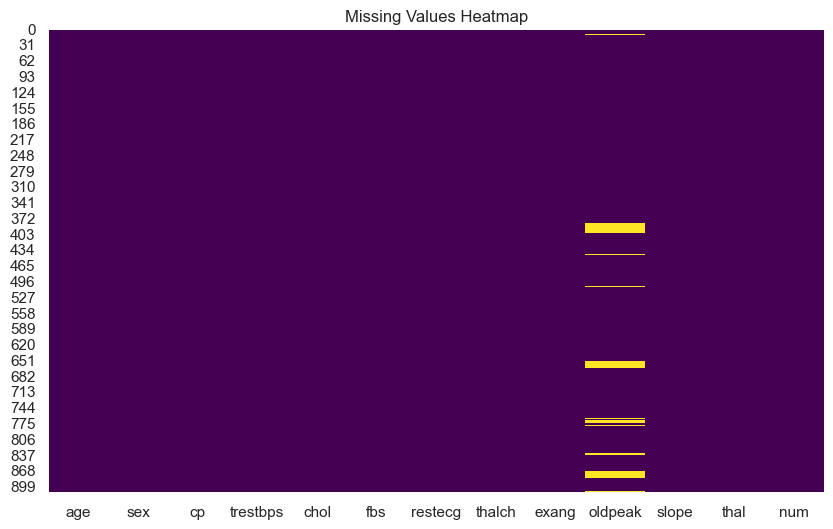

age: int64, Unique values: 49
sex: object, Unique values: 2
   Values: ['Male' 'Female']
cp: object, Unique values: 4
   Values: ['typical angina' 'atypical angina' 'asymptomatic' 'non-anginal']
trestbps: int64, Unique values: 85
chol: int64, Unique values: 228
fbs: bool, Unique values: 2
restecg: object, Unique values: 3
   Values: ['lv hypertrophy' 'normal' 'st-t abnormality']
thalch: int64, Unique values: 122
exang: object, Unique values: 4
   Values: [False True 'FALSE' 'TURE']
oldpeak: float64, Unique values: 53
slope: object, Unique values: 3
   Values: ['downsloping' 'flat' 'upsloping']
thal: object, Unique values: 3
   Values: ['fixed defect' 'normal' 'reversable defect']
num: int64, Unique values: 5


In [127]:
# Basic statistics
print("Descriptive statistics:")
print(df.describe())

# Check target distribution
print("\nTarget variable distribution:")
print(df['num'].value_counts())

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['num'].value_counts().plot(kind='bar')
plt.title('Distribution of Heart Disease Stages')
plt.xlabel('Heart Disease Stage')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Check for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Check data types and unique values
for column in df.columns:
    print(f"{column}: {df[column].dtype}, Unique values: {df[column].nunique()}")
    if df[column].dtype == 'object':
        print(f"   Values: {df[column].unique()}")

**3. Feature Engineering**

In [128]:
# Handle missing values in oldpeak (replace with median)
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].median())

# Convert categorical variables to numerical
label_encoders = {}
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']

for col in categorical_cols:
    # Handle the formula-based thal values by sampling from the three categories before fitting LabelEncoder for thal
    if col == 'thal':
        thal_categories = ['reversable defect', 'normal', 'fixed defect']
        df['thal'] = df['thal'].apply(lambda x: np.random.choice(thal_categories)
                                    if 'CHOOSE' in str(x) else x)
    le = LabelEncoder()
    # Print unique values before fitting for debugging
    print(f"Unique values in '{col}' before fitting LabelEncoder: {df[col].unique()}")
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


# Convert boolean columns to numeric
bool_cols = ['fbs', 'exang']
for col in bool_cols:
    # Handle mixed boolean and string types in 'exang' before converting to int
    if col == 'exang':
        df['exang'] = df['exang'].replace({'FALSE': False, 'TURE': True})
    df[col] = df[col].astype(int)

# Handle any remaining missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Verify data types
print("\nFinal data types:")
print(df.dtypes)

Unique values in 'sex' before fitting LabelEncoder: ['Male' 'Female']
Unique values in 'cp' before fitting LabelEncoder: ['typical angina' 'atypical angina' 'asymptomatic' 'non-anginal']
Unique values in 'restecg' before fitting LabelEncoder: ['lv hypertrophy' 'normal' 'st-t abnormality']
Unique values in 'slope' before fitting LabelEncoder: ['downsloping' 'flat' 'upsloping']
Unique values in 'thal' before fitting LabelEncoder: ['fixed defect' 'normal' 'reversable defect']

Final data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalch        int64
exang         int64
oldpeak     float64
slope         int64
thal          int64
num           int64
dtype: object


**4. Decision Tree Classification**

Decision Tree Performance:
Accuracy: 0.4505
Precision: 0.4887
Recall: 0.4505
F1-Score: 0.4680


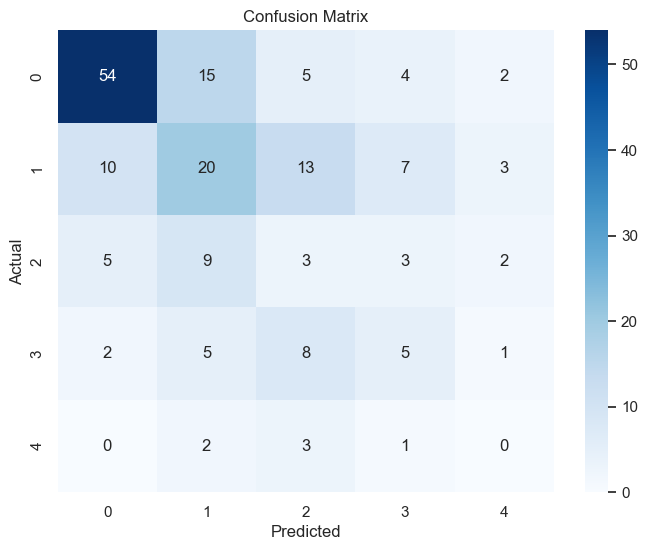


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        80
           1       0.39      0.38      0.38        53
           2       0.09      0.14      0.11        22
           3       0.25      0.24      0.24        21
           4       0.00      0.00      0.00         6

    accuracy                           0.45       182
   macro avg       0.30      0.29      0.29       182
weighted avg       0.49      0.45      0.47       182



In [129]:
# Prepare features and target
X = df.drop('num', axis=1)
y = df['num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Initialize and train Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

**5. Hyperparameter Tuning**

In [130]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                          param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train with best parameters
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)

print("\nOptimized Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")

Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.5674822862541331

Optimized Decision Tree Performance:
Accuracy: 0.5055
Precision: 0.4250
Recall: 0.5055
F1-Score: 0.4609


**6. Model Evaluation and Analysis**

Feature Importance:
     Feature  Importance
2         cp    0.562547
4       chol    0.176597
0        age    0.152926
8      exang    0.087281
3   trestbps    0.020649
1        sex    0.000000
6    restecg    0.000000
5        fbs    0.000000
7     thalch    0.000000
9    oldpeak    0.000000
10     slope    0.000000
11      thal    0.000000


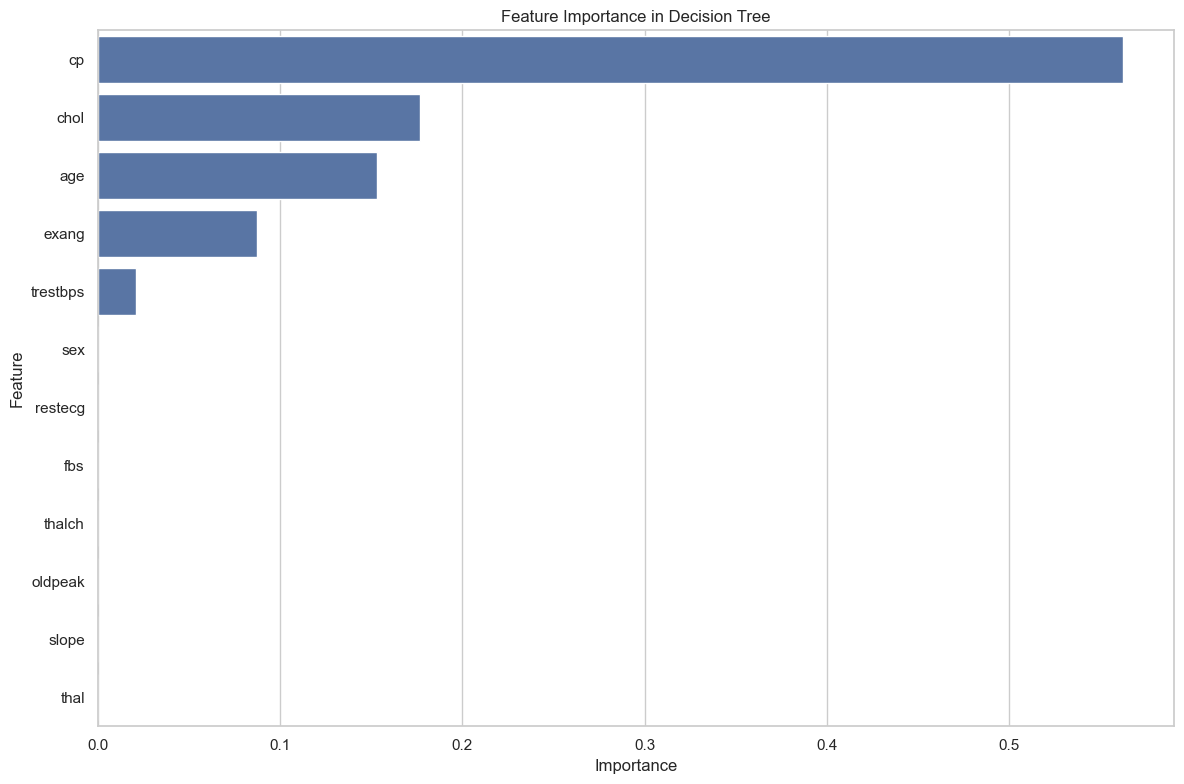

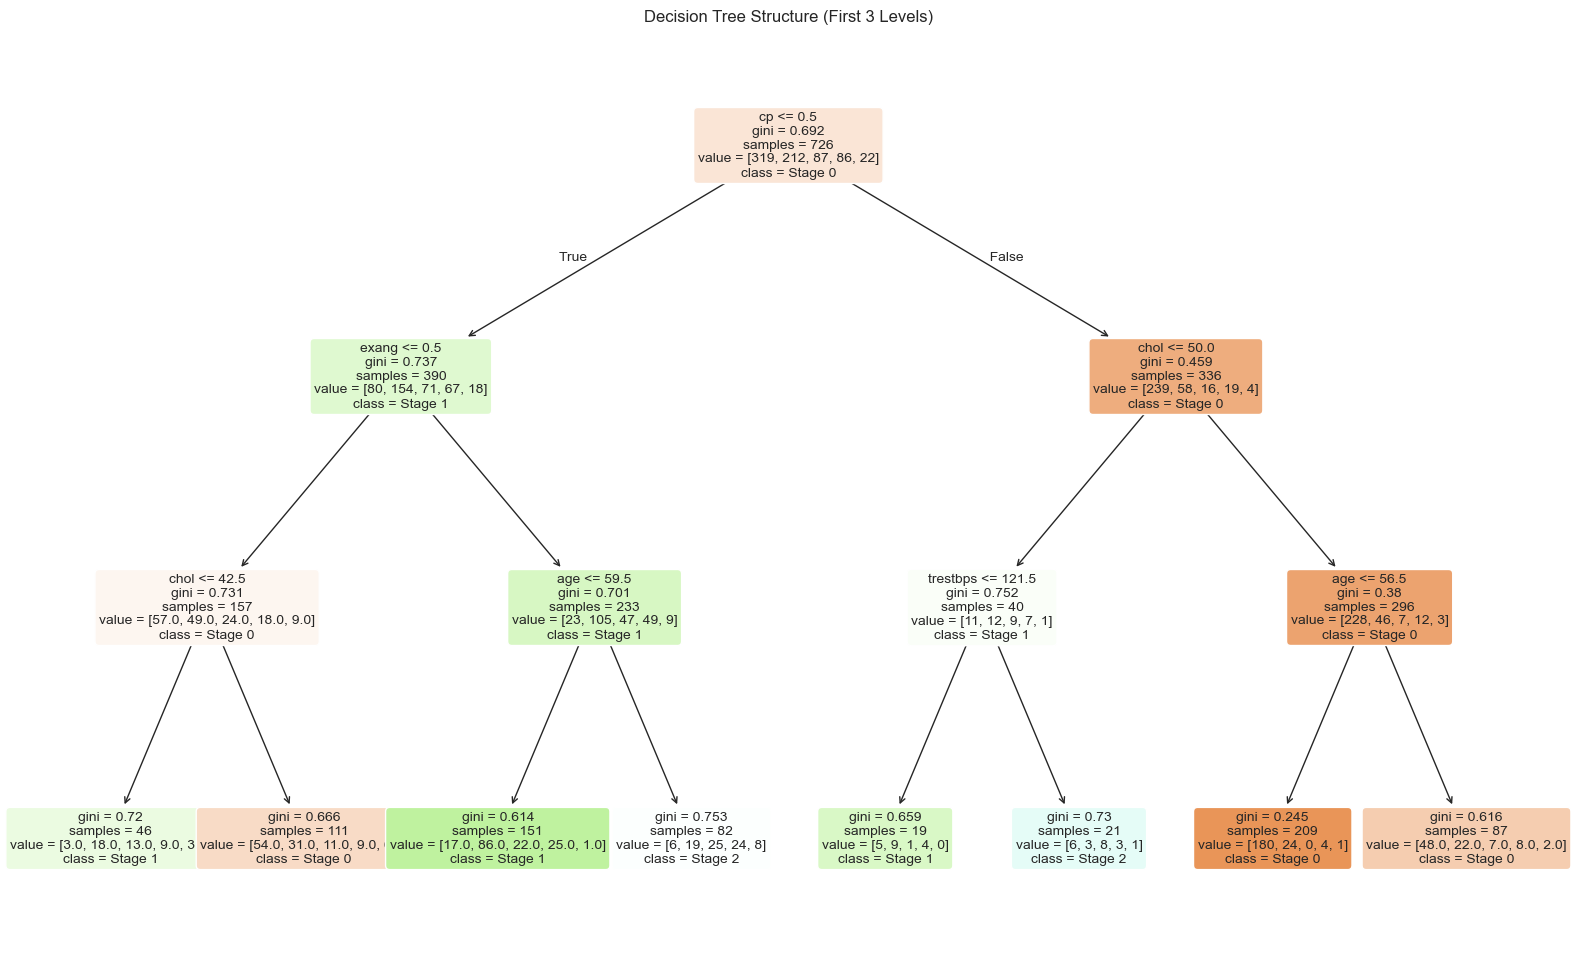


Key Decision Rules:
Node 0: cp <= 0.50
Node 1: exang <= 0.50
Node 2: chol <= 42.50
Node 5: age <= 59.50
Node 8: chol <= 50.00
Node 9: trestbps <= 121.50
Node 12: age <= 56.50

Baseline Accuracy (Majority Class): 0.4394


In [131]:
# Feature importance
feature_importance = best_dt.feature_importances_
feature_names = X.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Decision Tree')
plt.tight_layout()
plt.show()

# Visualize the decision tree (pruned for readability)
plt.figure(figsize=(20, 12))
plot_tree(best_dt,
          feature_names=feature_names,
          class_names=[f'Stage {i}' for i in range(5)],
          filled=True,
          rounded=True,
          max_depth=3,  # Limit depth for readability
          fontsize=10)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.show()

# Analyze specific rules
print("\nKey Decision Rules:")
# Get the first few decision rules
def print_rules(tree, feature_names, class_names):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        if children_left[node_id] != children_right[node_id]:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if is_leaves[i]:
            continue
        if node_depth[i] <= 3:  # Only show first few levels
            print(f"Node {i}: {feature_names[feature[i]]} <= {threshold[i]:.2f}")

print_rules(best_dt, feature_names, [f'Stage {i}' for i in range(5)])

# Compare with baseline (majority class)
baseline_accuracy = max(y.value_counts(normalize=True))
print(f"\nBaseline Accuracy (Majority Class): {baseline_accuracy:.4f}")